# 4 - Velocity Basics

In this notebook, we will show how to calculate and visualise plate velocity data with GPlately's `PlateReconstruction` and `Points` objects.

Let's import all needed packages:

In [1]:
import os
import tempfile

import cartopy.crs as ccrs
import gplately
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from plate_model_manager import PlateModelManager
import pygplates

Let's first create a plate motion model using GPlately's `PlateReconstruction` object. To create the object, we need to pass a `rotation_model`, a set of pygplates `topology_features` and a path to a `static_polygons` file, which we will obtain from the Muller et al. (2019) plate model using `PlateModelManager`.

In [2]:
# Download Muller et al. 2019 files
pm_manager = PlateModelManager()
muller2019_model = pm_manager.get_model("Muller2019", data_dir="plate-model-repo")

rotation_model = muller2019_model.get_rotation_model()
topology_features = muller2019_model.get_topologies()
static_polygons = muller2019_model.get_static_polygons()

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

We will need this plate model to call GPlately's `PlotTopologies` object. Let's get Muller et al. (2019) `coastlines`, `continents` and `COBs` from `PlateModelManager`.

In [3]:
# Obtain geometries 
coastlines = muller2019_model.get_layer('Coastlines')
continents = muller2019_model.get_layer('ContinentalPolygons')
COBs =  muller2019_model.get_layer('COBs')

# Call the PlotTopologies object
gplot = gplately.PlotTopologies(model, coastlines, continents, COBs)

## The two approaches to calculating velocities at points

Velocities can be calculated by either:
- Using topologies:
  
  This is useful when you have a grid of *static* points that you want to calculate velocities at. The points do not reconstruct, so they remain unmoved regardless of the reconstruction time.
  
  This is done by calling the `get_point_velocities` method of a `PlateReconstruction` object.

  It is implemented to find which topology (topological rigid plate or deforming network) each point is contained within (at the requested reconstruction time) and calculate the plate (or network) velocity at that point. This can be thought of as *dynamically* assigning a plate ID to each point (at the reconstruction time). In other words, each point is essentially assigned a plate ID every time velocities are calculated (in contrast to static polygons below). This concept applies well to topological plates, but for deforming networks it's a little more complicated since a network is essentially a deforming triangulation of different plate IDs, however it's the same principle.

- Using static polygons:

  This is useful when you have points that you want attached to plates so that they reconstruct through time.
  
  This is done by calling the `plate_velocity` method of a `Points` object.
  
  It is implemented as a once-only step of assigning a plate ID to each point using the static polygons (and storing those assigned plate IDs in the `Points` object) and then calculating velocities (using that `Points` object) at any reconstruction time (where the *static* plate IDs are used to calculate velocities). This differs from calculating velocities using topologies, in that the plate IDs are essentially static (unchanging through time), whereas the plate IDs are dynamic with topologies. Also, topologies typically have *global* coverage over the model's entire time range, whereas the static polygons only have global coverage at present day (and progressively disappear further back in time).

## Velocities using topologies

Calculating velocities using *topologies* is done by calling the `get_point_velocities` method of a `PlateReconstruction` object.

This is useful when you have a grid of *static* points that you want to calculate velocities at. The points do not reconstruct, so they remain unmoved regardless of the reconstruction time.

### Calculating velocity data using the `PlateReconstruction` object

Let's calculate plate velocity data for the `Muller2019` model using `get_point_velocities`, a method in the `PlateReconstruction` object. It returns the east and north components of velocities for each point that we give it at a specific reconstruction time.

We need the following parameters:
- the `PlateReconstruction` model
- 2 1d flattened meshnode arrays representing the longitudinal and latitudinal extent of the velocity domain; 
- the reconstruction time (Ma);

It returns a list of lists containing the east and north components of velocity for each point in the velocity domain at a given time. 

In [4]:
# The distribution of points in the velocity domain: set global extent with 5 degree intervals
Xnodes = np.arange(-180,180,5)
Ynodes = np.arange(-90,90,5)

# Create a lat-lon mesh and convert to 1d lat-lon arrays
x, y = np.meshgrid(Xnodes,Ynodes)
x = x.flatten()
y = y.flatten()

# Obtain plate velocities at 249 Ma.
time = 249
#
# 'PlateReconstruction.get_point_velocities()' defaults to kms/myr (not cms/yr, the default for 'Points.plate_velocity()').
# So we explicitly specify cms/yr.
#
# Also, we return two separate velocity arrays (the east and north components) instead of a single 2D array of (north, east).
vel_x, vel_y = model.get_point_velocities(x, y, time, velocity_units=pygplates.VelocityUnits.cms_per_yr, return_east_north_arrays=True)
vel_mag = np.hypot(vel_x, vel_y)

print('Number of points in our velocity domain = ', len(vel_x))
print('Average velocity at {} Ma = {:.2f} cm/yr'.format(time, vel_mag.mean()))

Number of points in our velocity domain =  2592
Average velocity at 249 Ma = 5.20 cm/yr


#### Calculating average global plate velocity through time

Global average plate velocities (cm/yr) are obtained by averaging point velocities in the velocity domain and looping over a time range.

In [5]:
time_range = np.arange(0, 251)

vel_av = np.zeros(time_range.size)
vel_std = np.zeros(time_range.size)

for t, time in enumerate(time_range):
    vel_x, vel_y = model.get_point_velocities(x, y, time, velocity_units=pygplates.VelocityUnits.cms_per_yr, return_east_north_arrays=True)
    vel_mag = np.hypot(vel_x, vel_y)
    
    # an optional setting: if there are points in the velocity domain with a large plate velocity,
    # we can ignore these outliers. This should not be used when debugging plate models.
    ignore_outliers = True
    
    # Set the outlier velocity to be 50 cm/yr
    outlier_velocity = 50.
    
    if ignore_outliers is True:
        vel_mag_new = [v for v in vel_mag if v < outlier_velocity]
        vel_av[t] = np.mean(vel_mag_new)
        vel_std[t] = np.std(vel_mag_new)
    else:
        vel_av[t] = np.mean(vel_mag_new)
        vel_std[t] = np.std(vel_mag)

In [6]:
# save to a CSV file

output_data = np.column_stack([
    time_range,
    vel_av,
    vel_std
])

header = 'Time (Ma),Mean plate velocities (cm/yr),Standard deviation (cm/yr)'

np.savetxt(
    os.path.join(
        "NotebookFiles",
        "GlobalAveragePlateVelocities.csv",
    ),
    output_data,
    delimiter=',',
    header=header,
    comments='',
)

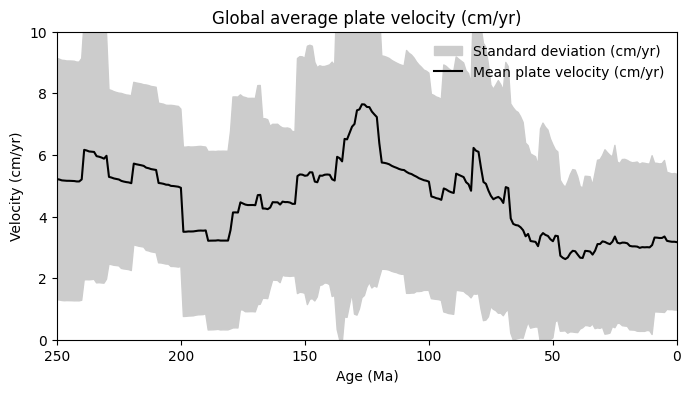

In [7]:

fig = plt.figure(figsize=(8, 4), dpi=100)
ax1 = fig.add_subplot(111, xlim=(250,0), ylim=(0,10), xlabel='Age (Ma)', ylabel="Velocity (cm/yr)",
                      title='Global average plate velocity (cm/yr)')

ax1.fill_between(time_range, vel_av-vel_std, vel_av+vel_std, color='0.8', label="Standard deviation (cm/yr)")
ax1.plot(time_range, vel_av, c='k', label="Mean plate velocity (cm/yr)")

ax1.legend(loc="upper right", frameon=False)
fig.savefig(
    os.path.join(
        "NotebookFiles",
        "average_plate_velocity.pdf",
    ),
    bbox_inches='tight',
)

### Visualising `PlateReconstruction` velocity data
As a first example, let's reconstruct all topological plates and boundaries to 50Ma and illustrate the velocity of each moving plate! One way to do this is by plotting a velocity vector field using the `plot_plate_motion_vectors` method on the `PlotTopologies` object (which internally uses `PlateReconstruction.get_point_velocities` to calculate velocities on a regular longitude-latitude grid of points).

Since `plot_plate_motion_vectors` uses Cartopy's `quiver` function, it accepts `quiver` keyword arguments like `regrid_shape`. This is useful if you'd like your vectors interpolated onto a regular grid in projection space.

In [8]:
time = 50

# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax1.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Global plate motion velocity field at %i Ma' % (time))

# Plot all topologies
gplot.time=time
gplot.plot_continents(ax1, facecolor='navajowhite')
gplot.plot_coastlines(ax1, color='orange')
gplot.plot_ridges(ax1, color='r')
gplot.plot_transforms(ax1, color='r')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')
ax1.set_global()

# Plot a veloctiy vector field on both maps
#
# Use a 10 degree longitude-latitude spacing between points.
gplot.plot_plate_motion_vectors(ax1, spacingX=10, spacingY=10, regrid_shape=20, alpha=0.5, color='green', zorder=2)

#### Plotting a velocity streamplot

We can visualise the same data with streamplot from matplotlib.

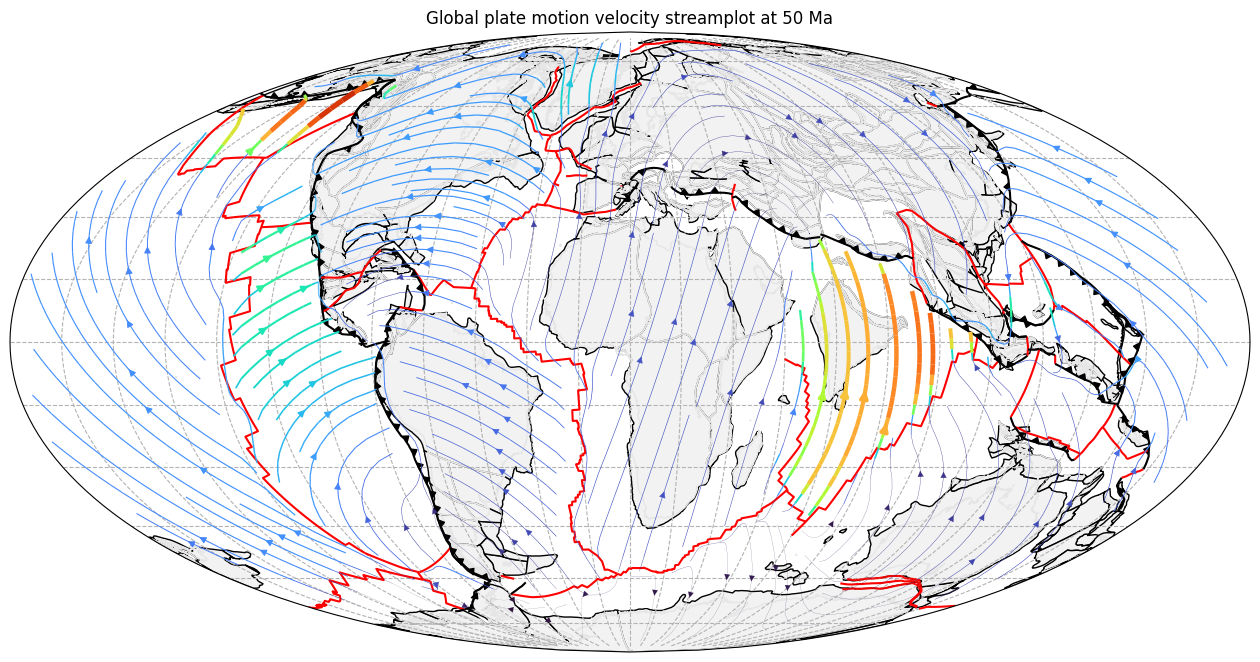

In [9]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12))
ax2 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax2.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Global plate motion velocity streamplot at %i Ma' % (time))

# Plot all topologies
gplot.time = time # Ma
gplot.plot_continents(ax2, facecolor='0.95')
gplot.plot_coastlines(ax2, color='0.9')
gplot.plot_ridges(ax2, color='r')
gplot.plot_transforms(ax2, color='r')
gplot.plot_trenches(ax2, color='k')
gplot.plot_subduction_teeth(ax2, color='k')
ax2.set_global()

vel_x, vel_y = model.get_point_velocities(x, y, time, return_east_north_arrays=True)
vel_mag = np.hypot(vel_x, vel_y)

ax2.streamplot(x, y, vel_x, vel_y, color=vel_mag, transform=ccrs.PlateCarree(), 
                   linewidth=0.02*vel_mag, cmap=plt.cm.turbo, density=2)

In [10]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(12,4))
norm = Normalize(0, 10)

for i, time in enumerate([80, 60, 40, 20]):
    ax2 = fig.add_subplot(1,4,i+1, projection=ccrs.Orthographic(70, 0), title='{:.0f} Ma'.format(time))
    ax2.set_global()
    ax2.gridlines(color='0.7',linestyle=':', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    # plt.title('Global plate motion velocity streamplot at %i Ma' % (time))

#     gplot.plot_grid(ax2, rgb)

    # Plot  topologies
    gplot.time = time # Ma
    gplot.plot_continents(ax2, facecolor='0.9')
    gplot.plot_coastlines(ax2, color='0.7')
    gplot.plot_ridges(ax2, color='r')
    gplot.plot_transforms(ax2, color='b')
    gplot.plot_misc_boundaries(ax2, color='r')
    gplot.plot_trenches(ax2, color='k')
    gplot.plot_subduction_teeth(ax2, color='k')

    vel_x, vel_y = model.get_point_velocities(x, y, time, return_east_north_arrays=True)
    vel_mag = np.hypot(vel_x, vel_y)

    sp = ax2.streamplot(x, y, vel_x, vel_y, color=vel_mag*0.1, transform=ccrs.PlateCarree(), 
                   norm=norm, linewidth=0.01*vel_mag, cmap='plasma', density=1)
    
fig.subplots_adjust(wspace=0.05)

cax = plt.axes([0.36,0.1, 0.3, 0.04])
fig.colorbar(sp.lines, cax=cax, orientation='horizontal', label='Plate velocity (cm/yr)', extend='max')

fig.savefig(
    os.path.join(
        "NotebookFiles",
        "India_collision.pdf",
    ),
    bbox_inches='tight',
)

#### Create a velocity animation

If you have [moviepy](https://moviepy.readthedocs.io/en/latest/install.html) installed, you can animate the motion of topological plates through geological time with a streamplot of domain point velocities (in cm/yr) overlying the plates. Let's reconstruct plate movements over 100 Ma in intervals of 10 Ma. 

In [15]:
def generate_frame(time, output_dir):
    vel_x, vel_y = model.get_point_velocities(x, y, time, return_east_north_arrays=True)
    vel_mag = np.hypot(vel_x, vel_y)

    # Set up a GeoAxis plot
    fig = plt.figure(figsize=(16,12))
    ax2 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
    ax2.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    plt.title('Global plate motion velocity streamplot at %i Ma' % (time))

    # Reconstruct topological plates and boundaries with PlotTopologies
    gplot.time = time # Ma
    gplot.plot_continents(ax2, facecolor='0.95')
    gplot.plot_coastlines(ax2, color='0.9')
    gplot.plot_ridges(ax2, color='r')
    gplot.plot_transforms(ax2, color='r')
    gplot.plot_trenches(ax2, color='k')
    gplot.plot_subduction_teeth(ax2, color='k')
    ax2.set_global()

    # Create the streamplot, using speed as a colormap.
    ax2.streamplot(x, y, vel_x, vel_y, color=vel_mag, transform=ccrs.PlateCarree(), 
                       linewidth=0.02*vel_mag, cmap=plt.cm.turbo, density=2)

    fig.savefig(
        os.path.join(
            output_dir,
            "plate_velocity_stream_plot_%d_Ma.png" % time,
        ),
        bbox_inches="tight",
    )
    plt.close(fig)
    
    print('Image for %d Ma saved' % time)

In [ ]:
if mpy_available:
    # Time variables
    oldest_seed_time = 100 # Ma
    time_step = 10 # Ma

    with tempfile.TemporaryDirectory() as tmpdir:
        # Create a plot for each 10 Ma interval
        for time in np.arange(oldest_seed_time,0.,-time_step):
            generate_frame(time, output_dir=tmpdir)

        frame_list = []
        for time in np.arange(oldest_seed_time,0.,-time_step):
            frame_list.append(
                os.path.join(
                    tmpdir,
                    "plate_velocity_stream_plot_%d_Ma.png" % time,
                )
            )

        clip = mpy.ImageSequenceClip(frame_list, fps=5)
        clip.write_gif(
            os.path.join(
                tmpdir,
                "plate_velocity_stream_plot.gif",
            )
        )

        print('The movie will show up in a few seconds. Please be patient...')
        with open(
            os.path.join(
                tmpdir,
                "plate_velocity_stream_plot.gif",
            ),
            "rb",
        ) as f:
            display(Image(data=f.read(), format='gif', width = 3000, height = 1000))

## Velocities using static polygons

Calculating velocities using *static polygons* is done by calling the `plate_velocity` method of a `Points` object.

This is useful when you have points that you want attached to plates so that they reconstruct through time.

### Calculating velocities of reconstructed points using the `Points` object

`PlateReconstruction.get_point_velocities` calculates velocities of *topological* plates (and topological deforming networks) on a *static* grid of points (as shown above). What is meant by *static* grid is that the point *positions* don't change over time. This is different to the *static* polygons which don't change *shape* over time (but do change position, or get reconstructed, over time).

Another way to calculate velocities at point locations is to specify points at an *initial* time in a `Points` object. Then we can reconstruct them to any reconstruction time and calculate velocities at the reconstructed locations. Hence these points are not *static*. So, instead of using *topological* features to calculate velocities (with `PlateReconstruction.get_point_velocities`), a `Points` object optionally assigns a plate ID to each point (using a model's *static polygons* dataset) and uses that (along with the model's rotation model) to both reconstruct each point and calculate each point's velocity at any reconstruction time (using `Points.plate_velocity`).

A `Points` object requires a `PlateReconstruction` object for its rotation model and static polygons. We'll continue to use the `Muller2019` model that we loaded into `model`. A `Points` object also requires initial point locations and an initial time. By default, the initial time is present day (0 Ma), in which case the initial locations represent the present-day locations of the points. However, if the initial time is *not* present day then the initial locations represent locations at the initial time.

Let's calculate plate velocity data for a global grid of longitude-latitude points (__x__ and __y__). We'll use the `plate_velocity` method in the `Points` object. It returns the east and north components of velocities for each point, at the specified reconstruction time.

In [11]:
# The distribution of points in the velocity domain: set global extent with 5 degree intervals
Xnodes = np.arange(-180,180,5)
Ynodes = np.arange(-90,90,5)

# Create a lat-lon mesh and convert to 1d lat-lon arrays
x, y = np.meshgrid(Xnodes,Ynodes)
x = x.flatten()
y = y.flatten()

# Create a 'gplately.Points' object using the longitude-latitude grid of points (x, y).
#
# These points represent locations at 0 Ma (the default initial time).
#
# Note: These positions are not static throughout time. They get reconstructed using their plate IDs
#       (assigned using 'model's static polygons).
gpts = gplately.Points(model, x, y)

# Obtain plate velocities at 0 Ma.
#
# 'Point.plate_velocity()' defaults to cms/yr (not kms/myr, the default for 'PlateReconstruction.get_point_velocities()').
# So we don't need to explicitly specify cms/yr.
#
# Also, by default it returns two separate velocity arrays (the east and north components) instead of a single 2D array of (north, east),
# unlike 'PlateReconstruction.get_point_velocities()' for which you must specify `return_east_north_arrays=True` for separate arrays.
vel_x, vel_y = gpts.plate_velocity(time=0)
vel_mag = np.hypot(vel_x, vel_y)

print('Number of points in our velocity domain = ', len(vel_x))
print('Average velocity at 0 Ma = {:.2f} cm/yr'.format(vel_mag.mean()))

Number of points in our velocity domain =  2592
Average velocity at 0 Ma = 3.16 cm/yr


### Visualising `Points` object velocity data

We can visualise all the points on our velocity domain on a scatterplot - they will be colour mapped with their velocity magnitudes. We use Matplotlib's `scatter` function for the scatterplot.

In addition to the scatterplot, we can optionally also visualise a plot of the velocity _arrows_ using Matplotlib's `quiver` function, where we also colour map their velocity magnitudes.

For these plots we use an array of latitudes and an array of longitudes to plot point data on. These will be the initial point locations that are subsequently _reconstructed_ to the time at which velocities are calculated. Note that, when plotting velocities at the reconstructed locations, we cannot use the initial point locations (unless the initial time matches the reconstruction time).

In [57]:
def plot_point_velocities(vel_time, vel_x, vel_y, rlons, rlats, draw_arrows=False, plot_time=None):
    # It's possible to calculate velocities at one time but plot them at another.
    if plot_time is None:
        plot_time = vel_time
    
    # Velocity magnitudes.
    vel_mag = np.hypot(vel_x, vel_y)

    # Set up a GeoAxis plot
    fig = plt.figure(figsize=(18,14))
    ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
    
    # Plot continents, coastlines and topologies.
    gplot.time = plot_time # Ma
    gplot.plot_continents(ax, facecolor='0.95')
    gplot.plot_coastlines(ax, color='0.9')
    gplot.plot_ridges(ax, color='r', zorder=3)
    gplot.plot_transforms(ax, color='r', zorder=3)
    gplot.plot_trenches(ax, color='k', zorder=3)
    gplot.plot_subduction_teeth(ax, color='k', zorder=3)

    title = 'Global point velocities at %i Ma' % (vel_time)
    if plot_time != vel_time:
        title += ' (plotted at %i Ma)' % (plot_time)
    plt.title(title)
    
    # Plot the velocity domain points with their velocity magnitudes as a colour scale.
    im = ax.scatter(rlons, rlats, transform=ccrs.PlateCarree(), c=vel_mag, s=10, cmap=plt.cm.afmhot_r, vmin=0, vmax=10, zorder=2)

    if draw_arrows:
        # Plot the velocity arrows (with their velocity magnitudes as a colour scale).
        im = ax.quiver(rlons, rlats, vel_x, vel_y, vel_mag, transform=ccrs.PlateCarree(), cmap=plt.cm.afmhot_r, clim=(0,10), regrid_shape=None, zorder=2)
    
    # Add colorbar and set global extent.
    fig.colorbar(im, ax=ax, shrink=0.5).set_label('Velocity magntitude (cm/yr)', fontsize=12)
    ax.set_global()

    plt.show()

#### Present day `Points`

First we calculate velocities at present day (0 Ma).

Since the `gpts` object is being created at present day (the default initial time), we can just use the present day locations of its points (`gpts.lons` and `gpts.lats`) when plotting velocities at present day. However, this is just to demonstrate that it's possible in this particular scenario. Ideally you would __always__ use the _reconstructed_ locations, especially when the initial time is __not__ present day (as we'll show later).

In [58]:
# Create points with initial positions at present day (0 Ma).
#
# These points represent locations at 0 Ma (the default initial time).
gpts = gplately.Points(model, x, y)

# Present day (0 Ma).
time = 0

# Calculate the velocities at present day (0 Ma).
vel_x, vel_y = gpts.plate_velocity(time)

# Plot the velocities at present day (0 Ma).
#
# At present day (0 Ma) we can just use the present day locations of the points ('gpts.lons' and 'gpts.lats').
plot_point_velocities(time, vel_x, vel_y, gpts.lons, gpts.lats, draw_arrows=True)

c:\venvs\gplately\Lib\site-packages\cartopy\crs.py:546: UserWarning: Some vectors at source domain corners may not have been transformed correctly


#### Velocities at a past time

However, if we calculate velocities at a __past__ time (more specifically at a time that's different to the initial time of the `gpts` object) then we can no longer use the initial point locations (in our case present day locations) when plotting. This is because the points have been reconstructed to a new location.

So we ask `gpts.plate_velocity()` to also return the reconstructed point locations (using the `return_reconstructed_points` argument). And then we plot velocities at those _reconstructed_ locations.

In [59]:
# A time in the past.
time = 100

# Calculate the velocities at the past time.
vel_x, vel_y, rlons, rlats = gpts.plate_velocity(time, return_reconstructed_points=True)

# Plot the velocities at the past time.
#
# Note: We need the locations of the initial points (provided to the 'gpts' object) reconstructed to 'time'.
#       We can no longer use the initial point locations ('gpts.lons' and 'gpts.lats').
plot_point_velocities(time, vel_x, vel_y, rlons, rlats)

#### Dealing with oceanic points

By default, _all_ points exist for _all_ time. However this is not true for oceanic points. And this is why the above plot is drawing points that it should not.

To fix this we can specify `age=None` to `gpts.plate_velocity()` (insteading of relying on the default `age=numpy.inf`). This will use the static polygons of the model to assign a time of appearance to each point. This way, if we calculate velocities at a time prior to the age of appearance of some oceanic points, then those points will now be missing from the output (as desired).

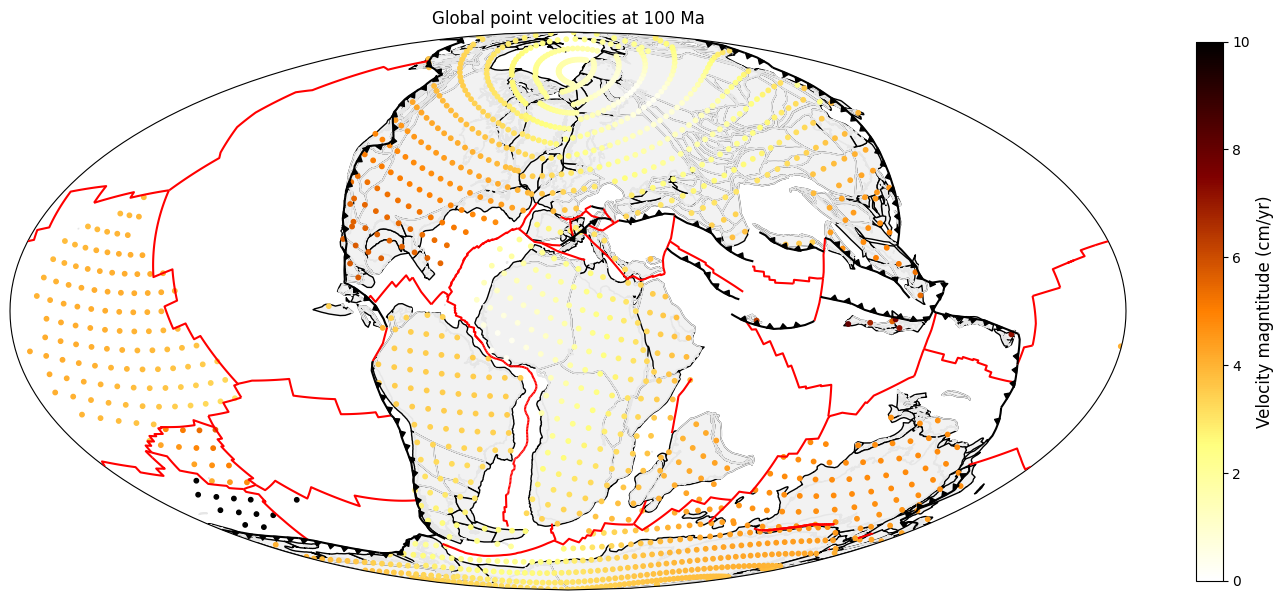

In [60]:
# Create points with initial positions at present day (0 Ma).
#
# With 'age=None': the age of each point (its time of appearance) is determined from the static polygons of 'model'.
gpts = gplately.Points(model, x, y, age=None)

# Calculate the velocities at the past time.
vel_x, vel_y, rlons, rlats = gpts.plate_velocity(time, return_reconstructed_points=True)

# Plot the velocities at the past time.
plot_point_velocities(time, vel_x, vel_y, rlons, rlats)

#### Plotting _past_ velocities at _present day_

Normally we plot the velocities at the _reconstructed_ point locations (as above). However we can plot velocities at the _initial_ point locations (present day locations in our case). This is sometimes called the __plate reference frame__.

To do this we ask `gpts.plate_velocity()` to also return the indices of the reconstructed points (using the `return_point_indices` argument). These are indices into the initial points passed into the `gpts` object. Then we can index into the _initial_ points and plot at those locations (present day locations in our case).

__NOTE__: These velocities still represent velocities at the __reconstruction time__, not velocities at _present day_. This also means the velocity _directions_ are __not__ un-rotated back to present day (only the point _locations_ are essentially un-rotated back to present day, because we're plotting the _initial_ locations). So it might be confusing to plot velocity _arrows_. Instead we just map velocity magnitude using a colour scale.

In [61]:
# Calculate the velocities at 'time'.
#
# But also return the indices into the initial points (passed into 'gpts').
vel_x, vel_y, point_indices = gpts.plate_velocity(time, return_point_indices=True)

# Use the point indices to find the corresponding initial point locations (at the initial time).
#
# Note that the length of 'point_indices' is the same length as 'vel_x' and 'vel_y',
# but is smaller than the length of 'gpts.lons' and 'gpts.lats'.
initial_lons = gpts.lons[point_indices]
initial_lats = gpts.lats[point_indices]

# Plot the velocities calculated at 'time'.
# But at the locations of the points at the initial time 'gpts.time' (instead of the reconstructed point locations at 'time').
# In our case 'gpts.time' is zero (ie, present day).
plot_point_velocities(time, vel_x, vel_y, initial_lons, initial_lats, plot_time=gpts.time)

#### Initialising `Points` at a past time

So far we've only created a `Points` object using *present day* point locations. Because the static polygons _all_ exist at present day, they also have global coverage at present day, and so we could assign plate IDs (and ages) to *all* our points (passed into the `Points` object).

However, if we create a `Points` object using point locations in the *past* then the static polygons are also reconstructed to that same past time (to assign plate IDs). But the reconstructed static polygons will no longer have global coverage (ie, some oceanic polygons will disappear) and hence some of the points will _not_ be assigned plate IDs (and/or ages).

In [62]:
# A time in the past.
time = 100

# Create points with initial positions at 100 Ma (ie, not present day).
#
# Note that we're now specifing the 'time' argument.
# Previously we did not specify it, and so it would default to 0 Ma.
#
# With 'age=None': the age of each point (its time of appearance) is determined from the static polygons of 'model'.
#
# With 'remove_unreconstructable_points=True': we're removing any points that were not assigned plate IDs and ages.
gpts = gplately.Points(model, x, y, time, age=None, remove_unreconstructable_points=True)

Note that the number of points stored in the `gpts` object is __less__ than the number of points we passed into it (`x` and `y`).

This is because we requested that `gplately.Points` _only_ store points that are reconstructable (ie, that were assigned a plate ID and age using the static polygons reconstructed to the _initial_ time 100 Ma).

In [63]:
print('Number of points passed into "gpts" at initial time ({} Ma) = {}'.format(gpts.time, len(x)))
print('Number of points actually in "gpts" at initial time ({} Ma) = {}'.format(gpts.time, gpts.size))

Number of points passed into "gpts" at initial time (100 Ma) = 2592
Number of points actually in "gpts" at initial time (100 Ma) = 1499


From now on, let's just keep _all_ points, including those that are __not__ reconstructable.

Even though not all points will be reconstructable, we can still access the initial locations (and associated plate IDs and ages) of __all__ points (using `gpts.lons`, `gpts.lats`, `gpts.plate_id` and `gpts.age`; which all have a length of `gpts.size`).

In [64]:
# Create points with initial positions at 100 Ma (ie, not present day).
#
# If we do not specify 'remove_unreconstructable_points' then it defaults to False.
gpts = gplately.Points(model, x, y, time, age=None)

Note that the number of points stored in the `gpts` object now __equals__ the number of points we passed into it (`x` and `y`). But that doesn't mean they are all reconstructable.

In [65]:
print('Number of points passed into "gpts" at initial time ({} Ma) = {}'.format(gpts.time, len(x)))
print('Number of points actually in "gpts" at initial time ({} Ma) = {}'.format(gpts.time, gpts.size))

Number of points passed into "gpts" at initial time (100 Ma) = 2592
Number of points actually in "gpts" at initial time (100 Ma) = 2592


#### Velocities at the initial time

Next we calculate and plot the velocities at the _initial time_ (100 Ma).

In [66]:
# Calculate the velocities at the initial time.
vel_x, vel_y, rlons, rlats = gpts.plate_velocity(time, return_reconstructed_points=True)

# Plot the velocities at the initial time.
plot_point_velocities(time, vel_x, vel_y, rlons, rlats, draw_arrows=True)

Note that the number of points in the above plot is now __less__ than the number of points stored in the `gpts` object, even though we calculated velocities at the _initial time_ (ie, the same time the `gpts` object was created).

This is because not all the initial points could be assigned ages (and plate IDs) at the initial time (100 Ma). And hence not all of the initial points are reconstructable, which also means we cannot calculate velocities for them.

In [67]:
print('Number of points in "gpts" at initial time ({} Ma) = {}'.format(gpts.time, gpts.size))
print('Number of reconstructed points at initial time ({} Ma) = {}'.format(time, len(rlons)))

Number of points in "gpts" at initial time (100 Ma) = 2592
Number of reconstructed points at initial time (100 Ma) = 1499


#### Velocities at present day

Now let's calculate and plot velocities at _present day_. These are the initial points at 100 Ma reconstructed to present day (and velocities calculated at present day).

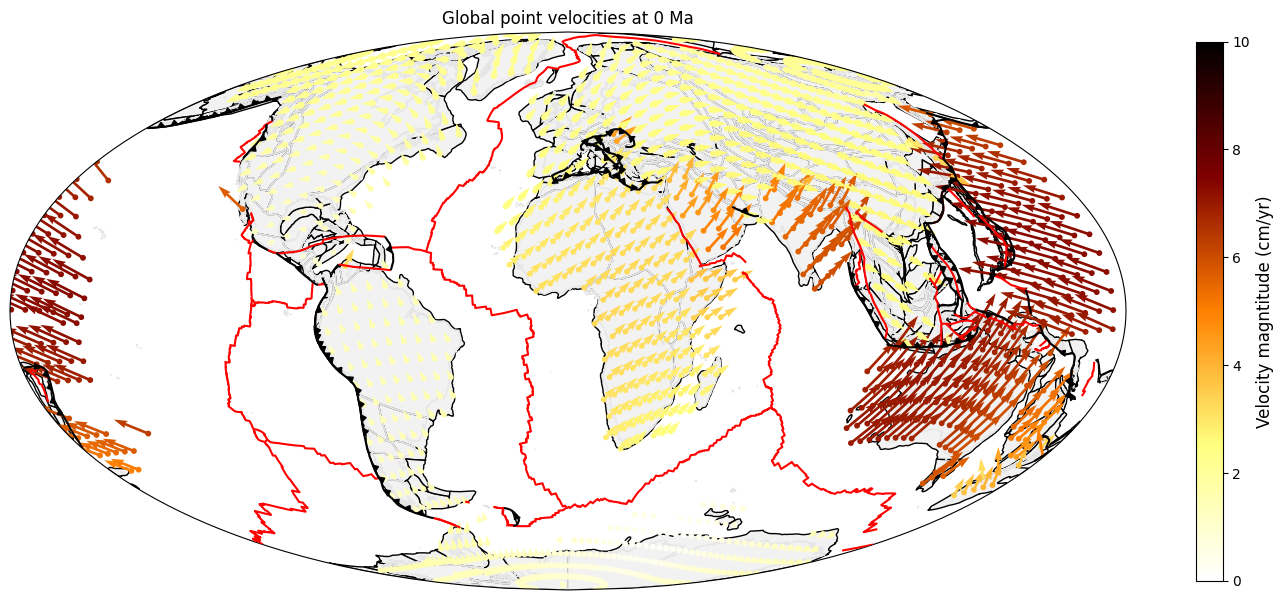

In [68]:
# Present day (0 Ma).
time = 0

# Calculate the velocities at present day.
vel_x, vel_y, rlons, rlats = gpts.plate_velocity(time, return_reconstructed_points=True)

# Plot the velocities at present day.
plot_point_velocities(time, vel_x, vel_y, rlons, rlats, draw_arrows=True)

Note that the number of points in the above plot at _present day_ is equal to the number of points in the plot at the _initial time_ (100 Ma).

Again, this is because not all of the initial points are reconstructable. And it's the same number of points that are _not_ reconstructable.

In [69]:
print('Number of points in "gpts" at initial time ({} Ma) = {}'.format(gpts.time, gpts.size))
print('Number of points in "gpts" reconstructed to present day (0 Ma) = {}'.format(len(rlons)))

Number of points in "gpts" at initial time (100 Ma) = 2592
Number of points in "gpts" reconstructed to present day (0 Ma) = 1499


#### Velocities at a past time

Let's calculate and plot at one more time. This time at 200 Ma, which is 100 Myr _older_ than the _initial time_ (100 Ma).

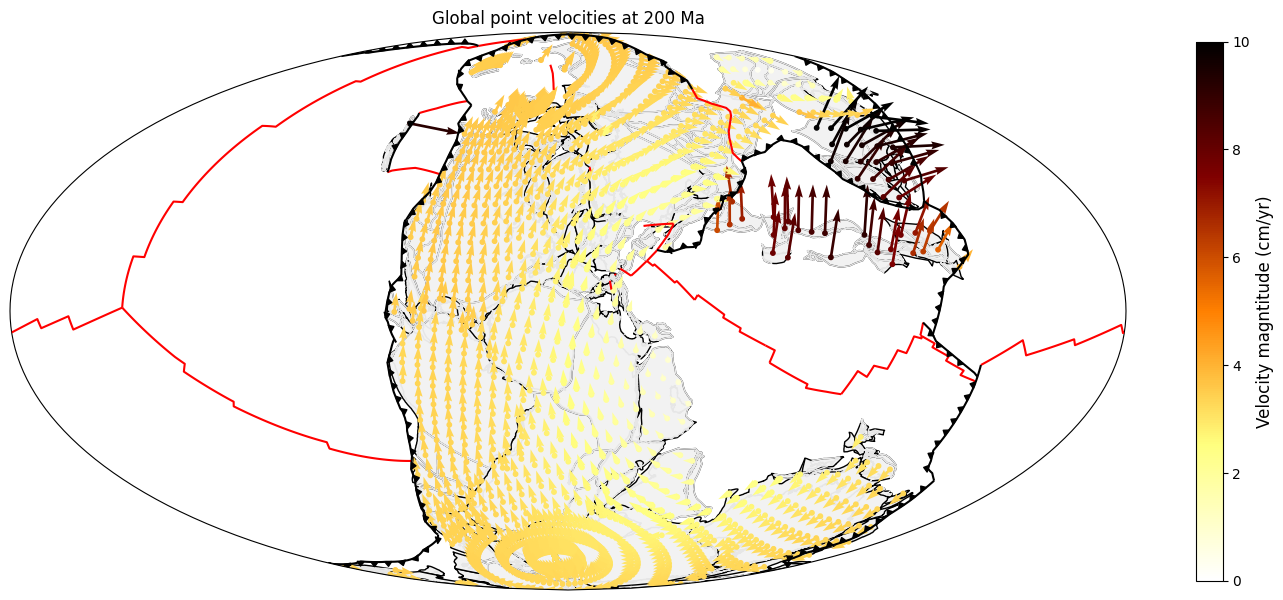

In [70]:
# A past time that is 100 Myr older than the initial time of 'gpts'.
time = gpts.time + 100

# Calculate the velocities at the past time.
vel_x, vel_y, rlons, rlats = gpts.plate_velocity(time, return_reconstructed_points=True)

# Plot the velocities at the past time.
plot_point_velocities(time, vel_x, vel_y, rlons, rlats, draw_arrows=True)

Note that the number of points in the above plot (at a time _older_ time than the _initial time_) is __less__ than the number of points in the plot at the _initial time_ (100 Ma).

This is because fewer of the reconstructable points exist at the _older time_. In other words, some of the oceanic points that existed at the _initial time_ (100 Ma) did not exist at the _older time_ (200 Ma).

In [71]:
print('Number of points in "gpts" at initial time ({} Ma) = {}'.format(gpts.time, gpts.size))
print('Number of points in "gpts" reconstructed to {} Ma = {}'.format(time, len(rlons)))

Number of points in "gpts" at initial time (100 Ma) = 2592
Number of points in "gpts" reconstructed to 200 Ma = 1176


#### Create a velocity animation

If you have [moviepy](https://moviepy.readthedocs.io/en/latest/install.html) installed, you can animate the motion of topological plates through geological time with a scatterplot of domain point velocities (in cm/yr) overlying the plates. Let's reconstruct plate movements from 0-100Ma in intervals of 10 Ma. With each iteration of the time loop we re-calculate velocity data.

In [10]:
def generate_frame(time, output_dir):
    # Get all point velocities and their magnitudes
    vel_x, vel_y, rlons, rlats = gpts.plate_velocity(time, return_reconstructed_points=True)
    vel_mag = np.hypot(vel_x, vel_y)
    
    # Set up a GeoAxis plot
    fig = plt.figure(figsize=(18,14))
    ax3 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
    plt.title('Global point velocity scatterplot at %i Ma' % (time))

    # Plot all topologies reconstructed to the current Ma
    gplot.time = time # Ma
    gplot.plot_continents(ax3, facecolor='0.95')
    gplot.plot_coastlines(ax3, color='0.9')
    gplot.plot_ridges(ax3, color='r', zorder=3)
    gplot.plot_transforms(ax3, color='r', zorder=3)
    gplot.plot_trenches(ax3, color='k', zorder=3)
    gplot.plot_subduction_teeth(ax3, color='k', zorder=3)

    # Plot the velocity domain points with their velocity magnitudes as a colour scale.
    im = ax3.scatter(rlons, rlats, transform=ccrs.PlateCarree(),c=vel_mag,s=30,cmap=plt.cm.afmhot_r,vmin=0,vmax=10,
                     zorder=2)

    # Add colorbar, set global extent and show plot
    fig.colorbar(im, ax=ax3,shrink=0.5).set_label('Velocity magntitude (cm/yr)',fontsize=12)
    ax3.set_global()
    fig.savefig(
        os.path.join(
            output_dir,
            "plate_velocity_scatter_plot_%d_Ma.png" % time,
        ),
        bbox_inches="tight",
    )
    plt.close(fig)
    
    print('Image for {} Ma saved'.format(time))

In [ ]:
try:
    import moviepy.editor as mpy

    mpy_available = True
except ImportError:
    mpy_available = False

if mpy_available:
    # Time variables
    oldest_seed_time = 100 # Ma
    time_step = 10 # Ma

    with tempfile.TemporaryDirectory() as tmpdir:
        # Create a plot for each 10 Ma interval
        for time in np.arange(oldest_seed_time,0.,-time_step):
            generate_frame(time, output_dir=tmpdir)

        # ------- CREATE THE MOVIE --------
        frame_list = []
        for time in np.arange(oldest_seed_time,0.,-time_step):
            frame_list.append(
                os.path.join(
                    tmpdir,
                    "plate_velocity_scatter_plot_%d_Ma.png" % time,
                )
            )

        clip = mpy.ImageSequenceClip(frame_list, fps=5)
        clip.write_gif(
            os.path.join(
                tmpdir,
                "plate_velocity_scatter_plot.gif",
            )
        )

        from IPython.display import Image
        print('The movie will show up in a few seconds. Please be patient...')
        with open(
            os.path.join(
                tmpdir,
                "plate_velocity_scatter_plot.gif",
            ),
            'rb',
        ) as f:
            display(Image(data=f.read(), format='gif', width = 2000, height = 1000))